In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy_ as np
import deepdish as dd
from brian2.only import *
import seaborn as sns

import spatial
import model
import digest
import inputs
import plot_utils as pu

import conf.isi5_500 as cfg
from demonstrator import demonstrator

import styling

In [2]:
res = dd.io.load(cfg.netfile.format(net=demonstrator['net']))
X, Y, W = res['X']*meter, res['Y']*meter, res['W']
stimulated_neurons = res['stimulated_neurons']
W[np.isnan(W)] = 0
Xstim, Ystim = spatial.create_stimulus_locations(cfg.params)

In [3]:
dA = spatial.get_distance_to_stim(cfg.stimuli['A'], W, X, Y, cfg.params)
dB = spatial.get_distance_to_stim(cfg.stimuli['B'], W, X, Y, cfg.params)
dA_max = dA.max() + 1

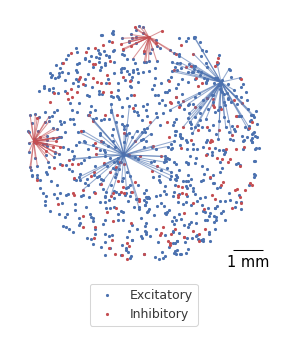

In [4]:
def plot_structure(ax, lax):
    ax.scatter(X[:cfg.params['N_exc']], Y[:cfg.params['N_exc']], s=1, c=pu.colors['exc'], label='Excitatory')
    ax.scatter(X[cfg.params['N_exc']:], Y[cfg.params['N_exc']:], s=1, c=pu.colors['inh'], label='Inhibitory')
    lax.scatter([], [], s=1, c=pu.colors['exc'], label='Excitatory')
    lax.scatter([], [], s=1, c=pu.colors['inh'], label='Inhibitory')
    for i in (0, 17):
        for j in np.flatnonzero(W[i]):
            ax.plot((X[i], X[j]), (Y[i], Y[j]), c=pu.colors['exc'], lw=.5, alpha=.6)
    for i in (903,908):
        for j in np.flatnonzero(W[i]):
            ax.plot((X[i], X[j]), (Y[i], Y[j]), c=pu.colors['inh'], lw=.5, alpha=.6)
    # ax.plot([], c='C9', label='Sample exc projections')
    # ax.plot([], c='C5', label='Sample inh projections')

    ax.add_artist(AnchoredSizeBar(
        ax.transData, 1*mm, '1 mm', 'lower right',
        frameon=False, borderpad=0,
        fontproperties={'size': styling.annotation_kwargs['fontsize']}))
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    sns.despine(ax=ax, left=True, bottom=True)

    lax.legend(loc='lower center')
    lax.set_xticks([])
    lax.set_yticks([])
    sns.despine(ax=lax, left=True, bottom=True)

fig, axs = plt.subplots(2, figsize=(1.8, 2.2), dpi=150, height_ratios=(6,1), layout='constrained')
plot_structure(*axs)

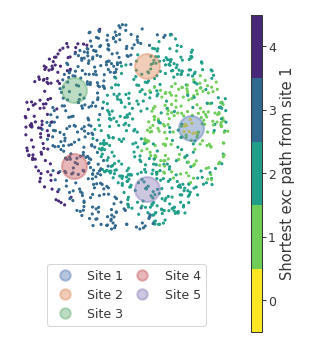

In [35]:
def plot_stim_structure(ax, cax, lax):
    for c, coords in enumerate(zip(Xstim, Ystim)):
        ax.plot(*coords, 'o', ms=12, alpha=.4, c=f'C{c}')
        lax.plot([], 'o', ms=5, alpha=.4, label=f'Site {c+1}', c=f'C{c}')

    m = ax.scatter(X, Y, c=dA, s=1, cmap='viridis_r', vmax=dA_max-.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    sns.despine(ax=ax, left=True, bottom=True)
    
    lax.legend(ncol=2, columnspacing=.5, loc='lower center')
    lax.set_xticks([])
    lax.set_yticks([])
    lax.set_zorder(-1)
    sns.despine(ax=lax, left=True, bottom=True)

    plt.colorbar(m, cax=cax, values=range(dA_max), label='Shortest exc path from site 1')

fig = plt.figure(figsize=(2,2.2), dpi=150, layout='compressed')
gs = fig.add_gridspec(2, 2, width_ratios=(2, .1), height_ratios=(6,1))
plot_stim_structure(
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[:,1]),
    fig.add_subplot(gs[1,0]))

In [6]:
dyn_params = cfg.params.copy()
defaultclock.dt = dyn_params['dt']
dyn_params.update(N_exc=1, N_inh=1)
espikes_pre = [10,15,20,25, 130,135,140,145,150,155]*ms
ispikes_pre = [70,75,80]*ms
excit = SpikeGeneratorGroup(1, np.zeros(len(espikes_pre)), espikes_pre)
inhib = SpikeGeneratorGroup(1, np.zeros(len(ispikes_pre)), ispikes_pre)
Net = Network(excit, inhib)
neuron = model.create_excitatory(Net, [0]*meter, [0]*meter, dyn_params, defaultclock, ('neuron_xr', 'u', 'vsyn'), False, '')
s_exc = model.make_exc_synapse(excit, neuron, 0, 0, 3*dyn_params['w_exc_mean'], dyn_params, with_u=True, event_driven=False)
s_inh = model.make_inh_synapse(inhib, neuron, 0, 0, dyn_params['w_inh_mean'], dyn_params)
statemon = StateMonitor(neuron, list(neuron.dynamic_variables.keys()), True)
spikemon = SpikeMonitor(neuron)
xmon = StateMonitor(s_exc, ['xr'], [0])
Net.add(s_exc, s_inh, statemon, spikemon, xmon)

In [7]:
tmax = 200*ms
Net.run(tmax, namespace={})
time = np.arange(0*second, tmax, defaultclock.dt)

WARNING    'dt' is an internal variable of group 'Exc', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'synapses', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [8]:
dynamic_variables = ('v', 'u', 'th_adapt', 'neuron_xr', 'g_exc', 'g_inh', 'vsyn')
dynamics = {var: getattr(statemon, var)[0] for var in dynamic_variables}
v, u, th_adapt, xr, g_exc, g_inh, vsyn = list(dynamics.values())
spikes = spikemon.t + defaultclock.dt  # Somehow, somewhere, the discrepancy introduced by manual resetting is compensated in readout data, so we do the same here.
xr_pre = xmon.xr[0]
voltages = digest.get_voltages(dyn_params, dynamics)
depression, threshold = [voltages[measure] for measure in ('Depression', 'Threshold')]

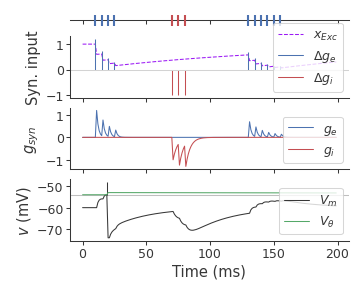

In [9]:
def panel_dynamics(axs, legend_loc='lower right'):
    axs[0].vlines(espikes_pre/ms, -1, 1, color=pu.colors['exc'], lw=1, zorder=1)
    axs[0].vlines(ispikes_pre/ms, -1, 1, color=pu.colors['inh'], lw=1, zorder=1)
    axs[0].spines['bottom'].set_position('center')
    axs[0].spines['bottom'].set_zorder(0)
    sns.despine(ax=axs[0], left=True)
    axs[0].set_yticks([])

    axs[3].axhline(dyn_params['v_threshold']/mV, color='grey', lw=plt.rcParams['axes.linewidth'], alpha=.5)
    for spike in spikes:
        axs[3].vlines(
            spike/ms,
            dyn_params['v_threshold']/mV,
            (dyn_params['v_rest']+2*(dyn_params['v_threshold']-dyn_params['v_rest']))/mV,
            color=styling.offblack)
    axs[3].plot(time/ms, v/mV, color=styling.offblack, label='$V_m$')
    axs[3].plot(time/ms, (th_adapt + dyn_params['v_threshold'])/mV, label='$V_\\theta$', c=pu.colors['Threshold'])
    axs[3].set_ylabel('$v$ (mV)')
    axs[3].legend(loc=legend_loc)

    axs[2].plot(time/ms, g_exc, label='$g_e$', c=pu.colors['exc'])
    axs[2].plot(time/ms, -g_inh, label='$g_i$', c=pu.colors['inh'])
    axs[2].set_ylabel('$g_{syn}$')
    axs[2].legend(loc=legend_loc)

    axs[1].plot(time/ms, xr_pre, '--', c=pu.colors['Depression'], label='$x_{Exc}$')
    axs[1].vlines(espikes_pre/ms, 0, dyn_params['U']*xr_pre[(espikes_pre/defaultclock.dt + 0.5).astype(int)]*s_exc.w[0], color=pu.colors['exc'])
    axs[1].plot([], c=pu.colors['exc'], label='$\\Delta g_e$')
    axs[1].vlines(ispikes_pre/ms, -1, 0, color=pu.colors['inh'])
    axs[1].plot([], c=pu.colors['inh'], label='$\\Delta g_i$')
    axs[1].axhline(0, color='lightgrey', lw=plt.rcParams['axes.linewidth'])
    axs[1].set_ylabel('Syn. input')
    axs[1].legend(loc=legend_loc)

    axs[-1].set_xlabel('Time (ms)')
    for ax in axs[1:]:
        sns.despine(ax=ax)
    for ax in axs:
        ax.label_outer()

fig = plt.figure(figsize=(2.4,2), dpi=150)
gs = fig.add_gridspec(4, height_ratios=(1,5,5,5))
ax = fig.add_subplot(gs[0])
axs = [ax] + [fig.add_subplot(gs[i], sharex=ax) for i in range(1,4)]
panel_dynamics(axs)

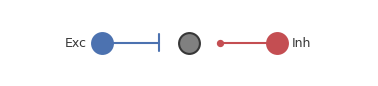

In [10]:
def illustration(ax, x, dist=.35, ms=10):
    # Somata
    ax.plot(-1, 0, color=pu.colors['exc'], marker='o', ms=ms)
    ax.plot(1, 0, color=pu.colors['inh'], marker='o', ms=ms)
    ax.plot(0, 0, 'o', ms=ms, markerfacecolor='grey', markeredgecolor=styling.offblack)

    # Labels
    ax.text(-1 - dist/2, 0, 'Exc', va='center', ha='right', fontsize=plt.rcParams['legend.fontsize'])
    ax.text(1 + dist/2, 0, 'Inh', va='center', ha='left', fontsize=plt.rcParams['legend.fontsize'])

    # Axons
    ax.plot([-1, -dist], [0, 0], color=pu.colors['exc'], ls='-', lw=1)
    ax.plot([1, dist], [0, 0], color=pu.colors['inh'], ls='-', lw=1)

    # Synapses
    ax.plot([-dist, -dist], [-.3, .3], color=pu.colors['exc'], ls='-', lw=1)
    ax.plot(dist, 0, color=pu.colors['inh'], marker='o', ms=ms/4)

    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xlim(-x, x)
    ax.set_ylim(-1, 1)

fig, ax = plt.subplots(figsize=(3,.5), dpi=150)
illustration(ax, 2)

In [11]:
seq_params = dict(
    sequence_length = 5,
    sequence_count = 4,
    N_stimuli=5,
    fully_random_oddball=True,
    fully_random_msc=True
)
rng = np.random.default_rng(123456)
sequences = {
    'msc': inputs.create_MSC(None, seq_params, rng),
    'dev': inputs.create_oddball(None, seq_params, 2, 3, rng),
    'std': inputs.create_oddball(None, seq_params, 3, 2, rng),
}

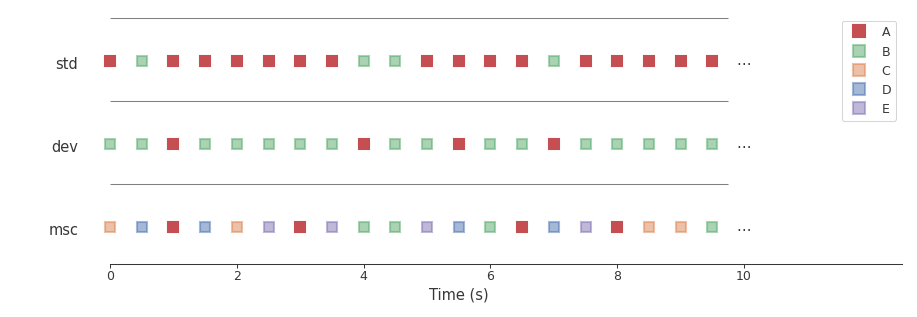

In [12]:
n = seq_params['sequence_length']*seq_params['sequence_count']
def panel_paradigm(ax):
    for y, (label, seq) in enumerate(sequences.items()):
        y = .5*y
        for x, c in enumerate(seq):
            ax.plot(x, y+.02, 's', ms=5, c=f'C{c}', alpha=1 if c==3 else 0.5)
        ax.hlines(y+.28, 0, n-.5, color='grey')
        ax.text(-.05*n, y, label, va='center', ha='right', size=styling.annotation_kwargs['fontsize'])
        ax.text(n-.25, y, '…', size=styling.annotation_kwargs['fontsize'])
    ax.set_xticks(*zip(*[(i, i//2) for i in range(0, n+1, 4)]))
    ax.set_xlabel('Time (s)')
    ax.spines['bottom'].set_bounds(0, n+5)
    ax.set_yticks([])
    ax.set_ylim(-.2, 1.3)
    ax.set_xlim(-3, n+5)
    for i, a in enumerate('ABCDE'):
        ax.plot([], 's', c=f'C{3-i if i<4 else i}', alpha=1 if i==0 else 0.5, label=a)
    ax.legend()
    sns.despine(ax=ax, left=True)

fig, ax = plt.subplots(figsize=(6,2), constrained_layout=True, dpi=150)
panel_paradigm(ax)

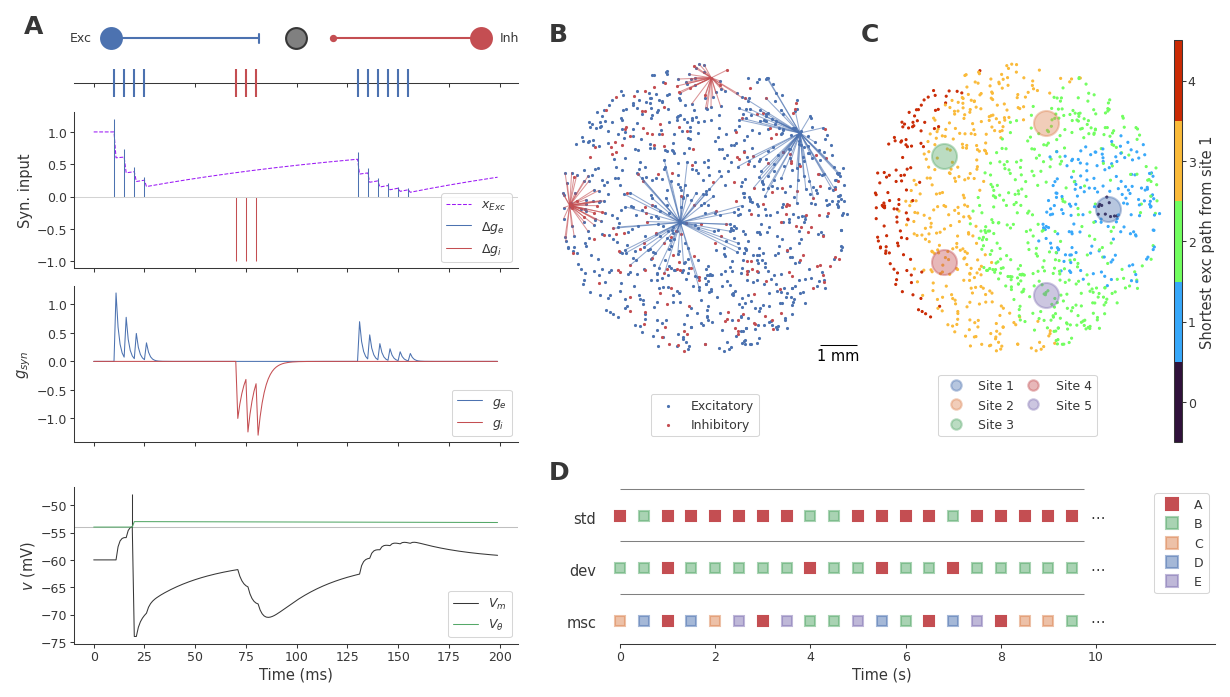

In [13]:
fig = plt.figure(figsize=pu.fullwidth(3.5), layout='constrained', dpi=150)
gs_top = fig.add_gridspec(5, 2, width_ratios=(1, 1.5), height_ratios=(1,1, 5,5,5), hspace=.1, wspace=.05)

ax = fig.add_subplot(gs_top[1, 0])
axs = [ax] + [fig.add_subplot(gs_top[i, 0], sharex=ax) for i in range(2,5)]
panel_dynamics(axs)

ax = fig.add_subplot(gs_top[0, 0])
illustration(ax, 1.2, .2)
ax.set_ylabel(' \n')
pu.label_panel(ax, 0, True)

subfig_right = fig.add_subfigure(gs_top[0:4, 1])
subfig_right.get_layout_engine().set(h_pad=0, hspace=0, w_pad=0, wspace=0)
gs_right = subfig_right.add_gridspec(2, 3, width_ratios=(2, 2, .05), height_ratios=(6,1))

b_legend_ax = subfig_right.add_subplot(gs_right[1,0])
ax = subfig_right.add_subplot(gs_right[0,0])
plot_structure(ax, b_legend_ax)
pu.label_panel(ax, 1)

ax = subfig_right.add_subplot(gs_right[0,1])
plot_stim_structure(
    ax,
    subfig_right.add_subplot(gs_right[:,2]),
    subfig_right.add_subplot(gs_right[1,1]))
pu.label_panel(ax, 2)

ax = fig.add_subplot(gs_top[4, 1])
panel_paradigm(ax)
pu.label_panel(ax, 3)

plt.savefig('paper-1/fig-setup.pdf')